# Credit Card Fraud Detection with Logistic Regression

---

Credit card fraud is a multi-billion dollar problem. It is a source of stress and inconvenience for cardholders, and can lead to significant expenses for credit card companies as well. 

This project uses the dataset found at https://www.kaggle.com/datasets/adityakadiwal/credit-card-fraudulent-transactions to explore the effectiveness of Logistic Regression in detecting fraudulent credit card transactions.

**Before we begin, here are a few notes regarding various project requirements not addressed elsewhere.** 
- **Industry-appropriate security features:** This notebook uses data found pulicly on Kaggle.com. No sensitive or private data are  included. As such no special security features are required for this notebook. 

- **Project monitoring and maintenance:** This project is being stored in a private GitHub repository and hosted publicly on Google Colab. Version control for any future updates and changes will be handled through pushing the updates to the private GitHub repository. Unfortunately Google Colab does not support automatic updates from private GitHub repositories, so updates to the publicly hosted version will be performed manually. 

---

## Step 1: Import libraries and tools
The following libraries and tools will be used for data analysis and for creating our machine learning model. 

In [1]:
# Libraries for exploratory data analysis and plotting graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

#Logistic Regression Model 
from sklearn.linear_model import LogisticRegression 

# Tools to transform, train and evaulate the model 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import plot_roc_curve 
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import datasets, metrics, model_selection, svm



## Step 2: Data Exploration



---

### Step 2.1: Importing data and creating a Panadas DataFrame
Our dataset is in CSV format. Panadas is a Python library that makes it easier to work with datatypes such as CSV. Below, we will import our dataset as a Pandas Dataframe. This will take the CSV data and format it into a more readable table format.  

In [2]:
fraud_data_frame = pd.read_csv("./data/CC_FRAUD.csv")
fraud_data_frame.head()

,DOMAIN,STATE,ZIPCODE,TIME1,TIME2,VIS1,VIS2,XRN1,XRN2,XRN3,XRN4,XRN5,VAR1,VAR2,VAR3,VAR4,VAR5,TRN_AMT,TOTAL_TRN_AMT,TRN_TYPE
0,CDRZLKAJIJVQHCN.COM,AO,675,12,12,1,0,0,1,1,0,1,2,1,16.680,34,0,12.95,12.95,LEGIT
1,NEKSXUK.NET,KK,680,18,18,1,0,0,0,0,0,1,3,0,37.880,23,0,38.85,38.85,LEGIT
2,XOSOP.COM,UO,432,3,3,1,0,0,1,1,0,1,3,1,-9.080,19,2,38.85,38.85,LEGIT
3,TMA.COM,KR,119,23,23,0,0,1,0,0,0,3,0,0,-6.392,18,0,11.01,11.01,LEGIT
4,VUHZRNB.COM,PO,614,9,9,0,0,0,1,0,0,1,3,0,42.512,7,0,12.95,12.95,LEGIT


### Step 2.2 Data Cleaning and Transformation 

In this section we will analyize the data to see what features need to be dropped or transformed. 

---

 First we will look at the target labels for this dataset. They can be found in the TRN_TYPE column. Values are labeled as either "LEGIT" or "FRAUD". Let's start by counting how many values fall into each category. 
 
#### Data Visualization Number 1: Legitimate Vs Fraudulent Values


Text(0.5, 0, '1 = Legit | 0 = Fraud')

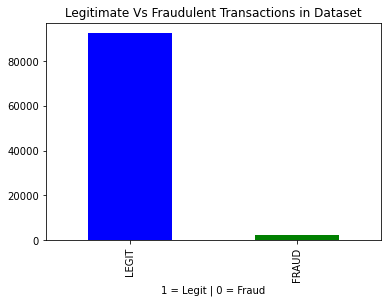

In [3]:
fraud_data_frame["TRN_TYPE"].value_counts().plot(kind="bar", color=["blue", "green"])
plt.title("Legitimate Vs Fraudulent Transactions in Dataset")
plt.xlabel("1 = Legit | 0 = Fraud")


The value counts indicate that this dataframe is unbalanced. The vast majority of records are for "LEGIT" transactions. This can be a problem for training the machine learning model. This is because models perform better when the ratio of labels is more even. 

Luckily, this is a large dataset. When we run our model we will use `imblean.under_sampling.RandomUnderSampler()` to randomly select an equal amount of "LEGIT" values to the available "FRAUD" values. 

---

Before we build the model, we must prepare the dataset in other ways. First let's see if there are any missing values. 

In [4]:
fraud_data_frame.isna().sum()

DOMAIN           0
STATE            0
ZIPCODE          0
TIME1            0
TIME2            0
VIS1             0
VIS2             0
XRN1             0
XRN2             0
XRN3             0
XRN4             0
XRN5             0
VAR1             0
VAR2             0
VAR3             0
VAR4             0
VAR5             0
TRN_AMT          0
TOTAL_TRN_AMT    0
TRN_TYPE         0
dtype: int64

---
It looks like there are no missing values. That's good.

Now let's check the datatypes of the values. It is important for all data to be numeric before we train our model. When we check the datatypes below, there are several non numeric columns. We will need to transform those before proceeding. 

In [5]:
fraud_data_frame.dtypes

DOMAIN            object
STATE             object
ZIPCODE            int64
TIME1              int64
TIME2              int64
VIS1               int64
VIS2               int64
XRN1               int64
XRN2               int64
XRN3               int64
XRN4               int64
XRN5               int64
VAR1               int64
VAR2               int64
VAR3             float64
VAR4               int64
VAR5               int64
TRN_AMT          float64
TOTAL_TRN_AMT    float64
TRN_TYPE          object
dtype: object

The first value we need to transform is the TRN_TYPE category. This category represents our target labels for the dataset. 
There are two values for this category so we can represent them as true and false with the numbers 1 and 0. We can see that the values have been converted properly on the updated DataFrame below. 

In [6]:
#First we will map the TRN_TYPE category from string values to numeric values
trn_type_dict = {"LEGIT":1, "FRAUD":0}
#Now we will use the map function to transform the values in the column 
fraud_data_frame["TRN_TYPE"] = fraud_data_frame['TRN_TYPE'].map(trn_type_dict)
fraud_data_frame.head()

,DOMAIN,STATE,ZIPCODE,TIME1,TIME2,VIS1,VIS2,XRN1,XRN2,XRN3,XRN4,XRN5,VAR1,VAR2,VAR3,VAR4,VAR5,TRN_AMT,TOTAL_TRN_AMT,TRN_TYPE
0,CDRZLKAJIJVQHCN.COM,AO,675,12,12,1,0,0,1,1,0,1,2,1,16.680,34,0,12.95,12.95,1
1,NEKSXUK.NET,KK,680,18,18,1,0,0,0,0,0,1,3,0,37.880,23,0,38.85,38.85,1
2,XOSOP.COM,UO,432,3,3,1,0,0,1,1,0,1,3,1,-9.080,19,2,38.85,38.85,1
3,TMA.COM,KR,119,23,23,0,0,1,0,0,0,3,0,0,-6.392,18,0,11.01,11.01,1
4,VUHZRNB.COM,PO,614,9,9,0,0,0,1,0,0,1,3,0,42.512,7,0,12.95,12.95,1


---
There are too many unique values in the domain category and the state category. This will make it difficult to work with those values. If we tried to transofrm them all there would be 9809 columns for each DOMAIN value, 53 columns for each state value and 94 columns for each zipcode value. It will be better to simply drop these columns.


In [7]:
#There are 9809 unique values in DOMAIN. That would make too many columns! 
len(fraud_data_frame.DOMAIN.unique())

fraud_data_frame = fraud_data_frame.drop('DOMAIN', axis=1)

fraud_data_frame.head()


,STATE,ZIPCODE,TIME1,TIME2,VIS1,VIS2,XRN1,XRN2,XRN3,XRN4,XRN5,VAR1,VAR2,VAR3,VAR4,VAR5,TRN_AMT,TOTAL_TRN_AMT,TRN_TYPE
0,AO,675,12,12,1,0,0,1,1,0,1,2,1,16.680,34,0,12.95,12.95,1
1,KK,680,18,18,1,0,0,0,0,0,1,3,0,37.880,23,0,38.85,38.85,1
2,UO,432,3,3,1,0,0,1,1,0,1,3,1,-9.080,19,2,38.85,38.85,1
3,KR,119,23,23,0,0,1,0,0,0,3,0,0,-6.392,18,0,11.01,11.01,1
4,PO,614,9,9,0,0,0,1,0,0,1,3,0,42.512,7,0,12.95,12.95,1


In [8]:
#There are 53 state values. These can be dropped as well.
len(fraud_data_frame.STATE.unique())
fraud_data_frame = fraud_data_frame.drop('STATE', axis=1)


In [9]:
# There are 94 ZIPCODE Values, although these are numeric, they are really more like categories. We will drop them too.
len(fraud_data_frame.ZIPCODE.unique())
fraud_data_frame = fraud_data_frame.drop('ZIPCODE', axis=1)

In [10]:
fraud_data_frame.head()

,TIME1,TIME2,VIS1,VIS2,XRN1,XRN2,XRN3,XRN4,XRN5,VAR1,VAR2,VAR3,VAR4,VAR5,TRN_AMT,TOTAL_TRN_AMT,TRN_TYPE
0,12,12,1,0,0,1,1,0,1,2,1,16.680,34,0,12.95,12.95,1
1,18,18,1,0,0,0,0,0,1,3,0,37.880,23,0,38.85,38.85,1
2,3,3,1,0,0,1,1,0,1,3,1,-9.080,19,2,38.85,38.85,1
3,23,23,0,0,1,0,0,0,3,0,0,-6.392,18,0,11.01,11.01,1
4,9,9,0,0,0,1,0,0,1,3,0,42.512,7,0,12.95,12.95,1


#### Data Visualization Number 2: Correlation Matrix

---
Now all non-numeric data has either been transformed or removed. Our data is almost ready to be trained. First lets create a correlation matrix to see if any other columns should be dropped. If there is a 1 to 1 relationship between two columns in the matrix, one of them should be dropped. 

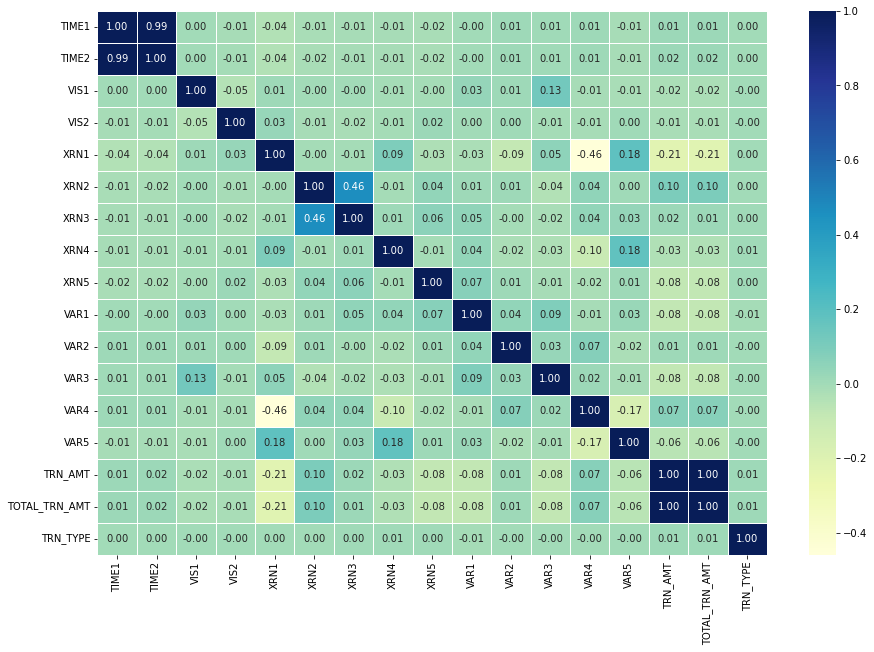

In [11]:
correlation_matrix = fraud_data_frame.corr() 
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(correlation_matrix, 
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu")


---
The matrix shows very strong correlations between TIME1 and TIME2. It also shows strong correlation between TRN_AMT and TOTAL_TRN_AMT. To resolve this TIME2 and TOTAL_TRN_AMT will be dropped. 

In [12]:
fraud_data_frame = fraud_data_frame.drop('TIME2', axis=1)
fraud_data_frame = fraud_data_frame.drop('TOTAL_TRN_AMT', axis=1)

---
We can see the improvement this has made in the updated correlation matrix.

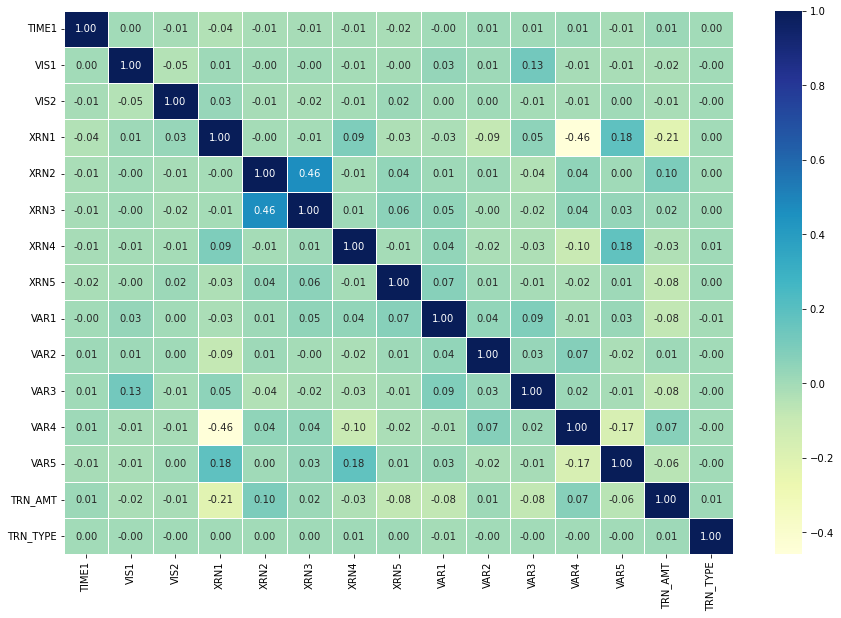

In [13]:
correlation_matrix = fraud_data_frame.corr() 
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(correlation_matrix, 
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu")


## Step 3: Training The Logistic Regression Model

---

In Step 2.1 we discovered that the dataset was very unbalanced. There were many more legitimate transactions than fraudulent ones. To get a better training result, we will use a technique called undersampling. Undersampling allows you to get a random sample of the larger value. This ensures the total ratio between both values is 50/50. Learn more at https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704. 

---

### Step 3.1 Creating the Train/Test Split

It is important to keep training and testing data separated. This ensures that the model can be properly evaluated. 

In [14]:
#First we need to create the features('X') and labels('y')

X = fraud_data_frame.drop('TRN_TYPE', axis=1)
y = fraud_data_frame['TRN_TYPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Step 3.2 Undersampling the "LEGIT" (1) Category
In the last section we transformed "LEGIT" to be a value of 1 and "FRAUD" to be a value of 0. The dataset is about 98% "LEGIT" and only 2% "FRAUD". We will need to complete resampling to get the 50% / 50% ratio that is ideal for training the model. 

According to https://stackoverflow.com/questions/66120039/undersampling-before-or-after-train-test-split it is the correct procedure to only to undersampling on the training data, not the testing data. We will follow this apprach next. 

In [15]:
#We must set a random seed before we begin model training.
#This will ensure that all output is comparable from the trained model.
np.random.seed(32) 
under_sampled = RandomUnderSampler()
X_resampled, y_resampled = under_sampled.fit_resample(X_train, y_train)

Text(0.5, 0, '1 = Legit | 0 = Fraud')

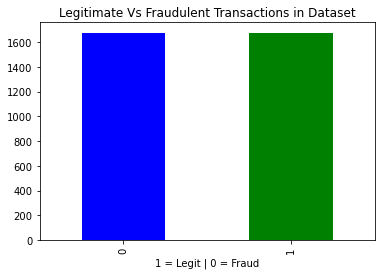

In [16]:
#Now we have equal data for each category
y_resampled.value_counts().plot(kind="bar", color=["blue", "green"])
plt.title("Legitimate Vs Fraudulent Transactions in Dataset")
plt.xlabel("1 = Legit | 0 = Fraud")

### Step 3.3 Training and Evaluating the Model

In [17]:
# First we will train the data using the resampled data
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_resampled, y_resampled)
logistic_regression_model.score(X_resampled, y_resampled)

0.5205847255369929

In [18]:
logistic_regression_model.score(X_test, y_test)

0.4980725563711253

---
Our first attempt to train the model has performed poorly. The ~53% score on the training data is about as good as chance. We will have to try some things to see if we can improve model performance. I found  post on Stack Overflow (https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work) that suggests trying the class_weight parameter for the LogisticRegression() model. This parameter will replicate the smaller class (ie. "FRAUD" values) until they are proportional to the larger class. The error report also suggests increasing the number of iterations permitted. We will do that as well. 

In [19]:
#Lets refit using the class_weight parameter

logistic_regression_model = LogisticRegression(class_weight='balanced', max_iter=1000)
logistic_regression_model.fit(X_train, y_train)
logistic_regression_model.score(X_train, y_train)


0.4803881444319757

In [20]:
logistic_regression_model.score(X_test, y_test)

0.477847599936632

---
This has also not yeielded a good result. Perhaps we can get a better result if we tune the model. GridSearchCV is an available module that searches parameter values to try to improve the results. You can learn more here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.

We will tune the logistic regression model based on code found in the course Zero to Mastery Machine Learning. The code will reccomended tuning parameters can be found here: https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-heart-disease-classification-video.ipynb



In [21]:
logistic_regression_grid = {"C": np.logspace(-4,4,30), "solver":["liblinear"], "class_weight":["balanced"]}

grid_search_logistic_regression = GridSearchCV(LogisticRegression(), param_grid=logistic_regression_grid, cv=5, verbose=True)

grid_search_logistic_regression.fit(X_resampled, y_resampled)




Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'class_weight': ['balanced'],
                         'solver': ['liblinear']},
             verbose=True)

In [22]:
grid_search_logistic_regression.score(X_test,y_test)

0.5240534403548609

Even with the Grid Search we were not able to tune the model for better results. Next we will take a closer look at the model with other analytic tools to get a sense of what's happening.

### Step 3.4 In Depth Accuracy Analysis

Our initial accuracy analysis suggests that this data set is not well suited towards predicting fraudulent vs legitimate transactions. Now we will use some additional metrics to get a better sense of how this dataset performs. 

In [23]:
#First we need to create an array of predictions based on the training data
y_predictions = logistic_regression_model.predict(X_test)



#### Data Visualization Number 3: ROC Curve

As with the accuracy score, the ROC curve suggests that this dataset is not very good at predicting fraudulent transactions. ROC curve basically shows how many false positives you would need to tolerate for your model to capture all true positive cases. The graph below indicates that all false positives would have to be included in order to capture all true positives within the model.

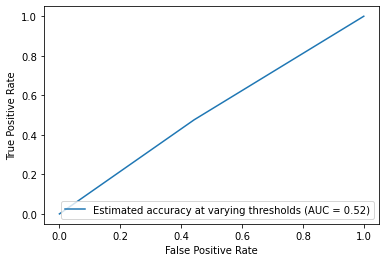

In [24]:
false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_predictions)
roc_auc = metrics.auc(false_positive, true_positive)
roc_graph = metrics.RocCurveDisplay(fpr=false_positive, tpr=true_positive, roc_auc = roc_auc, estimator_name="Estimated accuracy at varying thresholds" )
roc_graph.plot()


#### Data Visualization Number 4: Examining Feature Importance

The feature importance graph gives us a strong sense that most of the features have very little predictive power. 
Due to privacy concerns, many of the included features have been annonymized, so we don't know exactly what they represent. 
The only feature that has any strong predictive power is annonymized feature XRN4. 

<AxesSubplot:title={'center':'Impact of features'}>

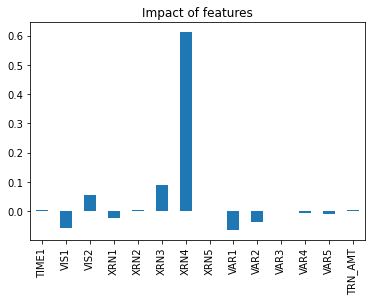

In [25]:
feature_dictionary = dict(zip(fraud_data_frame.columns, list(logistic_regression_model.coef_[0])))
feature_data_frame = pd.DataFrame(feature_dictionary, index=[0])
feature_data_frame.T.plot.bar(title="Impact of features", legend=False)

#### Data Visualization Number 5: Classification Report

The classification report provides several metrics to get a better sense of the predictive power of the dataset. In the dataframe below 0 = Fraudulent and 1 = Legitimate. 

* Precision: Is the ratio of true positives divided by the sum of true positives + false positives. This table indicates that the model had very little difficulty finding legitimate transactions, but struggled to identify fraudulent transactions. 

* Recall: Recall reflects the precentage of positive cases for each outcome that were actually detected. Only about 50% of each outcome were properly detected according to this report. 

* F1 Score: This measures what percentage of positive predictions were actually correct. As we can see for fraudulent transactions (0), only 4% of guesses were correct. 

* Support: This shows how many cases from each class were reviewed. Using the class_weight 'balanced' parameter resulted in 393 fraudulent transactions and 18544 legitimate transactions being included. We could run these numbers again with the resampled data, but given its performance on accuracy scores, this would not likely be much different. 

In [26]:
fraud_classification_report = classification_report(y_test, y_predictions, output_dict=True)
classification_report_data_frame = pd.DataFrame(fraud_classification_report).transpose()
classification_report_data_frame.round(2)

,precision,recall,f1-score,support
0,0.02,0.56,0.05,418.00
1,0.98,0.48,0.64,18519.00
accuracy,0.48,0.48,0.48,0.48
macro avg,0.50,0.52,0.34,18937.00
weighted avg,0.96,0.48,0.63,18937.00


**Data Visualization Number 6: Confusion Matrix**
The confusion matrix indicates that the model was very bad at detecting fraudulent outcomes. 

Text(7.5, 0.5, 'Predicted values')

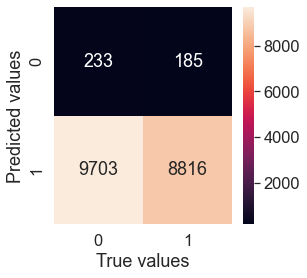

In [44]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(confusion_matrix(y_test, y_predictions), annot=True, fmt="g")
plt.xlabel("True values")
plt.ylabel("Predicted values")
